
# Data Preparation

## Imports

In [1]:
import os.path
from os.path import isfile, join
import os
from os import listdir
from osgeo import gdal
import errno
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

In [2]:
# for coloured print statements
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
path_labels = os.getcwd() + "/1_labeled_data/tif/"
cutouts_path = os.getcwd() + "/2_cutouts/"
path_satellite = "/home/jovyan/work/satellite_data/"

In [4]:
def print_files(path = os.getcwd()):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    print(path, onlyfiles)
print_files(path_labels)

/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/ ['22-01-05-uploaded.tif', '22-01-05.TIF', 'check-labels-jp2-capizalized-22-01-05.TIF', 'labels-jp2-tif-22.01-05.tif', '22-01-05-test-3-without-tif.tif', 'now.tif', '22-01-30.tif', '22-01-06-with-tif.tif']


### 0.1 Data Inspection

In [5]:
# Import Image with GDAL
dataset = gdal.Open(path_satellite + "2629BD_2018.tif")

In [6]:
# General Dataset Information
def inspect_tif(dataset):
    # print("1. General TIF Data:")
    # print("Metadata:",7 dataset.GetMetadata())
    # print("Type Image: ", type(dataset))
    # print("Projection: ", dataset.GetProjection())
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
    # print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
    #                         dataset.GetDriver().LongName))
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Raster Band
    band = dataset.GetRasterBand(1)
    # print("2. Raster Band:")
    # print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

    min = band.GetMinimum()
    max = band.GetMaximum()
    if not min or not max:
        (min,max) = band.ComputeRasterMinMax(True)
    print("Min={:.3f}, Max={:.3f}".format(int(min),int(max)))

    # if band.GetOverviewCount() > 0:
    #     print("Band has {} overviews".format(band.GetOverviewCount()))

    # if band.GetRasterColorTable():
    #     print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))
        
    size_x_px = dataset.RasterXSize
    size_y_px = dataset.RasterYSize
    pixel_size = (dataset.GetGeoTransform()[1], dataset.GetGeoTransform()[5])
    size_x = size_x_px * pixel_size[0]
    size_y = size_y_px * pixel_size[1]
    # print("# Pixels in Image = ({}, {}) with a Raster Count of {}".format(size_x_px, size_y_px, dataset.RasterCount))
    # print("Size of one Pixel in cm = {}".format(tuple([100000*x for x in pixel_size])))
    # print("Size Covered by Image / Image Size = ({}m, {}m)".format(round(1000*size_x, 2), abs(round(1000*size_y, 2))))
inspect_tif(dataset)

Size is 108224 x 107798 x 3
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
Min=0.000, Max=255.000


In [7]:
some_dataset = gdal.Open(path_satellite + "2627DC_2018.tif")
inspect_tif(some_dataset)

Size is 107608 x 107249 x 3
Origin = (27.497387693796565, -26.74753635381557)
Pixel Size = (2.3770193857792506e-06, -2.3770193857792447e-06)
Min=0.000, Max=240.000


In [8]:
# optional conversion to np array
# channel = np.array(dataset.GetRasterBand(1).ReadAsArray())
# print(channel.shape)

In [9]:
# Read the raster band as separate variable
#band = dataset.GetRasterBand(1)

# Check type of the variable 'band'
#type(band)

# Data type of the values
#gdal.GetDataTypeName(band.DataType)

In [10]:
# band1 = labels.GetRasterBand(1) # Red channel
# band2 = labels.GetRasterBand(2) # Green channel
# band3 = labels.GetRasterBand(3) # Blue channel

In [11]:
#labels.GetRasterBand()

Idea Training Process:
1. Load training set (labels with corresponding input TIFs)
2. Create cutouts of labeled training data
3. Train model on data
4. Evaluate model

Idea Prediction Process:
5. Create cutouts of unlabeled data
6. Predict cutouts

Function Overview
Training: load labels -> create_cutouts(label_file) -> fit(unlabeled_cutouts, labeled_cutouts) -> evaluate(?)
Prediction: load dats -> create_cutouts(label_file) -> predict(unlabeled_cutouts)

In [12]:
def isfile(filepath: str = None):
    # if filepath does not exists, an error is thrown
    if not os.path.isfile(filepath): raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filepath) #print("File does not exist.")

In [13]:
def preview_tif(tif_filepath: str = None):
    isfile(tif_filepath)
    img = rasterio.open(tif_filepath)
    if img: show(img)
    else: print("img unable to be loaded at this moment")

In [14]:
def create_cutouts(path_label: list = None, label_file: list = None, cutout_window: tuple = None):
    #print("load_tif.cutout_window:", load_tif.cutout_window)
    # upper/lower (u/l) left/right (l/r) coordinates 
    ulx, xres, xskew, uly, yskew, yres  = label_file.GetGeoTransform()
    width, height = label_file.RasterXSize, label_file.RasterYSize
    lrx = ulx + width * xres
    lry = uly + height * yres
    
    # Label and satellite image do not have the same origin. So it has to be standardized/adjusted.
    # If it is a satellite image, the cutout_window is not passed. Hence, it is set
    # If it is a label, the cutout_window is copied from the satellite image
    if (cutout_window == None): load_tif.cutout_window = (ulx, uly, lrx, lry)
    # TODO BEI LABELS WIRD DAS AUCH AUSGEFÜHRT, WEIL CUTOUT-WINDOW NICHT EXISTIERT
    else: ulx, uly, lrx, lry = cutout_window[0], cutout_window[1], cutout_window[2], cutout_window[3]
    print("Übergebenes cutout_window:", cutout_window)
    #print("load_tif.cutout_window:", load_tif.cutout_window)
    # corner & cener coordinates can be checked in the terminal with 
    # $ gdalinfo '/home/jovyan/work/satellite_data/FILE.tif'
    # determine cutout window of size: 512x512 px
    cutout_size = 512 *2 # =patch_size
    
    no_of_x_cutouts = 2 #int(width / cutout_size)
    no_of_y_cutouts = 2 #int(height / cutout_size)
    
    for cutout_y in range(no_of_y_cutouts):
        for cutout_x in range(no_of_y_cutouts):
            if cutout_window == None:
                # ul_corner = (ulx, uly)
                # lr_corner = (lrx, lry)
                # base value (upper left corner of image + how far the cutout is moved in each iteration
                crop_ulx = ulx + (cutout_x * cutout_size * xres)
                crop_uly = uly + (cutout_y * cutout_size * yres)
                # base value (upper left corner of defined cutout) + cutout size (converted in coordinates with resolution)
                crop_lrx = crop_ulx + cutout_size * xres
                crop_lry = crop_uly + cutout_size * yres
                
                cropped_window = (crop_ulx,crop_uly,crop_lrx,crop_lry)
            else: cropped_window = cutout_window
                
            print(f"{bcolors.OKBLUE}Cropped Window: {cropped_window}{bcolors.ENDC}")
            # export cropped raster
            cutout_filename = path_label.replace(".tif", "") + "-{}-{}.tif".format(cutout_x, cutout_y)
            cutout_path = cutouts_path + cutout_filename
            # print(f"Cutout: {bcolors.OKBLUE}{cutout_path}{bcolors.ENDC}")
            gdal.Translate(cutout_path, label_file, projWin = cropped_window) #label_file is the tif file

            # set tje cutout window for the next iteration and for the labels
            load_tif.cutout_window = cropped_window
            
            # preview tif
            #load_tif([cutout_path])
            cutout = gdal.Open(cutout_path)
            # check if gdal is able to open file
            if cutout:
                print(f"{bcolors.OKGREEN}0 Success: {cutout_filename}{bcolors.ENDC}") # complete path: cutout_path
                inspect_tif(cutout)
            preview_tif(cutout_path)
    # close tif
    cutout_path = label_file = cropped_window = None

In [15]:
def load_tif(files_list: list = None, is_label: bool = False, cutout_window: tuple = None):
    if cutout_window: load_tif.cutout_window = cutout_window
    # loop through array of file names
    for filename in files_list:
        complete_filepath = (path_labels if is_label else path_satellite) + filename
        # check if filepath exists
        if not os.path.isfile(complete_filepath):
            print("Filepath does not exist: {}".format(complete_filepath)) 
            continue
        # open file
        label_file = gdal.Open(complete_filepath)
        # check if gdal is able to open file
        if label_file:
            # print(f"{bcolors.OKBLUE}{filename}{bcolors.ENDC}")
            print(f"{bcolors.OKGREEN}0 Success:{bcolors.ENDC}{bcolors.OKBLUE}{filename}{bcolors.ENDC}") 
            inspect_tif(label_file)
            # if is_label:
            print(f"{bcolors.UNDERLINE}Cutouts:{bcolors.ENDC}")
            # create cutouts
            create_cutouts(filename, label_file, cutout_window)
            continue
        print(f"{bcolors.FAIL}1 Failure:{bcolors.ENDC}" + complete_filepath) #"File cannot be loaded." #"Filepath exists: ", os.path.isfile(tif_filepath), 

### 0.2 Load Labels

In [16]:
label_files = ["22-01-30.tif"] #, "now.tif"

In [17]:
"""previews = ["2629BD_2018-0-3.tif", "2629BD_2018-0-4.tif", "2629BD_2018-0-5.tif", 
"2629BD_2018-0-6.tif", "2629BD_2018-0-0.tif", "2629BD_2018-0-1.tif", 
"2629BD_2018-1-0.tif","2629BD_2018-1-1.tif"]
for img in previews:
    preview_tif(cutouts_path + img)"""

'previews = ["2629BD_2018-0-3.tif", "2629BD_2018-0-4.tif", "2629BD_2018-0-5.tif", \n"2629BD_2018-0-6.tif", "2629BD_2018-0-0.tif", "2629BD_2018-0-1.tif", \n"2629BD_2018-1-0.tif","2629BD_2018-1-1.tif"]\nfor img in previews:\n    preview_tif(cutouts_path + img)'

In [18]:
# load_tif(["2629BD_2018.tif", "2620BB_2016.tif", "2620BC_2009.tif", 
# "2620BC_2013.tif", "2620BC_2016.tif"], is_label = False, cutout_window = None)

In [19]:
files = ["2629BD_2018.tif"] # "2620BB_2016.tif", "2620BC_2009.tif", 
# "2620BC_2013.tif", "2620BC_2016.tif"
# load_tif(files, is_label = False, cutout_window = None)

## Development

In [20]:
def satellite_label_cutout(satellite_images: list = None, labels: list = None):
    load_tif(satellite_images, False, None) # (29.8732755, -26.3700055)
    
    print("cutout_window:", load_tif.cutout_window)
    # er übernimmt das letzte Cutout window von dem Satelitenbilder => Funktionen verschachteln (oder in dict (bild, cutout-window) speichern, das aber nicht so schön)
    # wie wäre es mit Funktion für testen: preview & cutten der Bilder mit custom cutout-window
    load_tif(labels, True, load_tif.cutout_window)

0 Success:2629BD_2018.tif
Size is 108224 x 107798 x 3
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
Min=0.000, Max=255.000
Cutouts:
Übergebenes cutout_window: None
Cropped Window: (29.746877767434313, -26.247113163017453, 29.749307529287886, -26.249542924871026)
0 Success: 2629BD_2018-0-0.tif
Size is 1024 x 1024 x 3
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
Min=0.000, Max=200.000


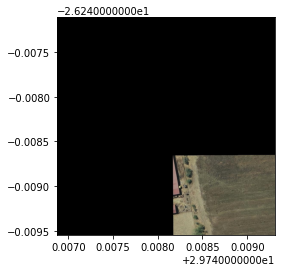

Cropped Window: (29.749307529287886, -26.247113163017453, 29.75173729114146, -26.249542924871026)
0 Success: 2629BD_2018-1-0.tif
Size is 1024 x 1024 x 3
Origin = (29.749307529287886, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
Min=0.000, Max=167.000


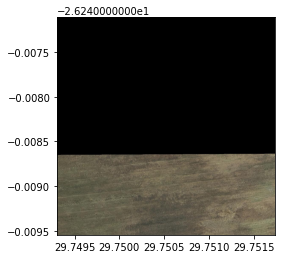

Cropped Window: (29.746877767434313, -26.249542924871026, 29.749307529287886, -26.2519726867246)
0 Success: 2629BD_2018-0-1.tif
Size is 1024 x 1024 x 3
Origin = (29.746877767434313, -26.249542924871026)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
Min=0.000, Max=200.000


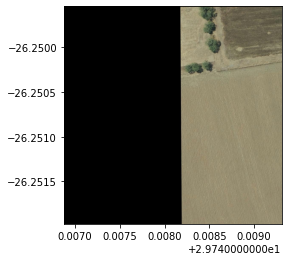

Cropped Window: (29.749307529287886, -26.249542924871026, 29.75173729114146, -26.2519726867246)
0 Success: 2629BD_2018-1-1.tif
Size is 1024 x 1024 x 3
Origin = (29.749307529287886, -26.249542924871026)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
Min=64.000, Max=182.000


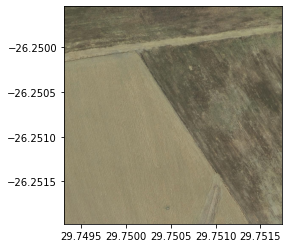

cutout_window: (29.749307529287886, -26.249542924871026, 29.75173729114146, -26.2519726867246)
0 Success:22-01-30.tif
Size is 4112 x 11377 x 4
Origin = (29.748224553, -26.248672807786964)
Pixel Size = (1.5679484435797747e-05, -1.5679484435797747e-05)
Min=80.000, Max=255.000
Cutouts:
Übergebenes cutout_window: (29.749307529287886, -26.249542924871026, 29.75173729114146, -26.2519726867246)
Cropped Window: (29.749307529287886, -26.249542924871026, 29.75173729114146, -26.2519726867246)
0 Success: 22-01-30-0-0.tif
Size is 155 x 155 x 4
Origin = (29.74930643742607, -26.249535179430932)
Pixel Size = (1.5679484435797747e-05, -1.5679484435797747e-05)
Min=255.000, Max=255.000


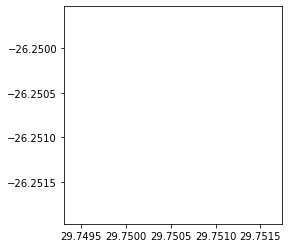

Cropped Window: (29.749307529287886, -26.249542924871026, 29.75173729114146, -26.2519726867246)
0 Success: 22-01-30-1-0.tif
Size is 155 x 155 x 4
Origin = (29.74930643742607, -26.249535179430932)
Pixel Size = (1.5679484435797747e-05, -1.5679484435797747e-05)
Min=255.000, Max=255.000


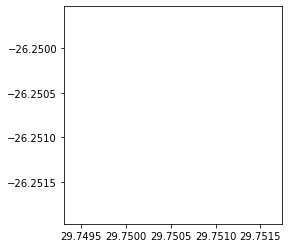

Cropped Window: (29.749307529287886, -26.249542924871026, 29.75173729114146, -26.2519726867246)
0 Success: 22-01-30-0-1.tif
Size is 155 x 155 x 4
Origin = (29.74930643742607, -26.249535179430932)
Pixel Size = (1.5679484435797747e-05, -1.5679484435797747e-05)
Min=255.000, Max=255.000


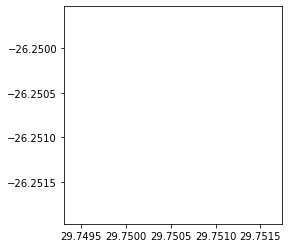

Cropped Window: (29.749307529287886, -26.249542924871026, 29.75173729114146, -26.2519726867246)
0 Success: 22-01-30-1-1.tif
Size is 155 x 155 x 4
Origin = (29.74930643742607, -26.249535179430932)
Pixel Size = (1.5679484435797747e-05, -1.5679484435797747e-05)
Min=255.000, Max=255.000


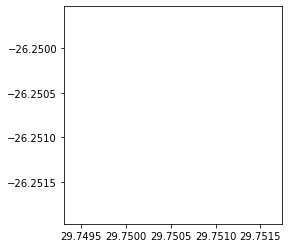

In [21]:
satellite_label_cutout(satellite_images = ["2629BD_2018.tif"], labels = ["22-01-30.tif"])
# unteres-rechte Cutout-Ende nicht gleich aufgrund von unterschiedlicher Resolution

In [22]:
def number_of_files_in_dir(dir: str = cutouts_path):
    number_of_files_in_dir.initial_count = 0
    for path in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, path)):
            number_of_files_in_dir.initial_count += 1
    return number_of_files_in_dir.initial_count

In [23]:
def remove_cutouts():
    number_of_files_in_dir()
    print("{} files are being deleted.".format(number_of_files_in_dir.initial_count))
    for f in os.listdir(cutouts_path):
        if f == ".ipynb_checkpoints": continue
        print(os.path.join(cutouts_path, f))
        os.remove(os.path.join(cutouts_path, f))
remove_cutouts()

12 files are being deleted.
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/2629BD_2018-0-1.tif.msk
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/2629BD_2018-1-1.tif.msk
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/2629BD_2018-0-1.tif
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/22-01-30-0-1.tif
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/2629BD_2018-0-0.tif
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/2629BD_2018-0-0.tif.msk
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/2629BD_2018-1-0.tif.msk
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/2629BD_2018-1-1.tif
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/22-01-30-0-0.tif
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/22-01-30-1-0.tif
/home/jovyan/wo

## Compare Satellite Image with Label

In [24]:
def cutout(files_list: list = None, cutout_window: tuple = None):
    for filename in files_list:
        complete_filepath = path_satellite + filename
        file = gdal.Open(complete_filepath)
        print(complete_filepath)
        cutout_filepath = cutouts_path + "warp-coutout-" + filename
        gdal.Warp(complete_filepath, file, cutlineDSName = cutout_window, 
                  cropToCutline = True, dstNodata = np.nan)
        # destName0rDestDS, srcDS0rSrcDSTab
        
        """array = file.GetRasterBand(1).ReadAsArray()
        plt.imshow(array) 
        plt.colorbar()"""
        
        #preview_tif(cutout_filepath)
        # TODO: Change Label Resolution ×Res, yRes
        # cropToCutline Ausschnitt von Label & Satellite zu cutten 
        # clipped = gdal.Warp(complete_filepath, file, cutlineDSName = "some_file.shp", cropToCutline = True, dstNoData = np.nan)
        
        # preview_tif(complete_filepath)
        """scanline = band.ReadRaster(xoff=0, yoff=0,
                        xsize=band.XSize, ysize=1,
                        buf_xsize=band.XSize, buf_ysize=1,
                        buf_type=gdal.GDT_Float32)"""
        

In [25]:
window = (29.746877767434313, -26.247113163017453, 29.76293355949657, -26.26316895507971)
files = ["2629BD_2018.tif"]
#cutout(files, cutout_window = window) #, labels = ["22-01-30.tif"]))